## GOAL: predict whether an edge (interaction) between two proteins should be included in a pathway (label 1) or not (label 0)

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import EdgeConv, NNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score

In [3]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 2


In [4]:
# set device to CUDA
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Data Loading:

**Pytorch Geometric `DataLoader` object from saved data:**

In [5]:
union_ppi = pd.read_csv('processed-data/union_ppi.txt', sep='\t', header=None)
unique_nodes = set(union_ppi[0].tolist() + union_ppi[1].tolist())
label_id_map = {label: idx for idx, label in enumerate(sorted(unique_nodes))}
num_nodes = len(label_id_map)
print(f"Total unique nodes: {num_nodes}")

inv_label_map = {idx: label for label, idx in label_id_map.items()}

Total unique nodes: 17407


In [6]:
data_list = torch.load('dataset.pt', weights_only=False)

In [7]:
print("Total number of data objects:", len(data_list))

for i, data in enumerate(data_list[:5]):
    print(f"\nData object {i}:")
    print("  Node features (x) size:", data.x.size())
    print("  Edge index size:", data.edge_index.size())
    print("  Edge attributes size:", data.edge_attr.size())
    print("  Edge labels (y) size:", data.y.size())

Total number of data objects: 820

Data object 0:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090, 1])
  Edge labels (y) size: torch.Size([202090, 1])

Data object 1:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090, 1])
  Edge labels (y) size: torch.Size([202090, 1])

Data object 2:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090, 1])
  Edge labels (y) size: torch.Size([202090, 1])

Data object 3:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090, 1])
  Edge labels (y) size: torch.Size([202090, 1])

Data object 4:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090

### Class Weight Calculation:

- Calculate the weight for the positive class to handle class imbalance
- needed since the number of negative samples (non-selected edges) is much higher than positive samples (selected edges)
- weighting the **loss function** helps the model to learn from the minority class effectively

In [8]:
def calculate_class_weights(data_list):
    # concat all labels into single tensor
    y = torch.cat([data.y for data in data_list]).cpu().numpy()
    # count the number of pos and negative samples
    num_positive = y.sum()
    num_negative = len(y) - num_positive
    # calculate the weight --> ratio of negative samples to positive samples
    # so that loss function balances the contribution of both classes
    pos_weight = torch.tensor([num_negative / (2 * num_positive)]).to(device)
    return pos_weight

pos_weight = calculate_class_weights(data_list)
print(f"Positive class weight: {pos_weight.item()}")

Positive class weight: 7362.594285968186


### Train-test split:

In [9]:
train_ratio = 0.8
train_size = int(train_ratio * len(data_list))
test_size = len(data_list) - train_size

In [10]:
# train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

In [11]:
# Retrieve the file names from the train split
# train_indices = train_dataset.indices 
# train_file_names = [data_list[idx].file_name for idx in train_indices]

In [12]:
# Save the train_file_names to a txt file
# with open('train_files.txt', 'w') as f:
#     for fname in train_file_names:
#         f.write(f"{fname}\n")

### Train-test split: from existing train split file

In [13]:
with open('normalized_train_files.txt') as f:
    train_files = set(f.read().splitlines())

#Partition data_list
train_dataset = [data for data in data_list if data.file_name in train_files]
test_dataset  = [data for data in data_list if data.file_name not in train_files]

print(f"Training on {len(train_dataset)} graphs; testing on {len(test_dataset)} graphs.")

Training on 656 graphs; testing on 164 graphs.


### Edge Sampling

- technique that oversamples the positive edges to address class imbalance
- duplicate positive edges in dataset to increase representation during training - so that the model sees more examples
- oersampling helps the model to better learn the characteristics of the minority class (selected edges), improving its ability to classify them correctly

In [14]:
def edge_sampling(data_list, sampling_ratio=0.5):
    """
    Oversample edges from the minority class (positive edges).
    Args:
        data_list: List of PyG data objects.
        sampling_ratio: Ratio of minority class edges to add.
    Returns:
        Augmented data_list with oversampled positive edges.
    """
    augmented_data_list = []
    for data in data_list:
        y = data.y.cpu().numpy()
        # get the indices of positive and negtive edges
        positive_indices = np.where(y == 1)[0]
        negative_indices = np.where(y == 0)[0]
        # oversample positive edges
        num_positive = len(positive_indices)
        # fraction of +ve edges are randomly sampled with replacement
        num_samples = int(sampling_ratio * num_positive)
        # stores the indices of the sampled positive edges
        sampled_indices = np.random.choice(positive_indices, num_samples, replace=True)
        # connectivity information (source and target nodes) for the sampled edges:
        sampled_edge_index = data.edge_index[:, sampled_indices]
        # edge features for sampled edges:
        sampled_edge_attr = data.edge_attr[sampled_indices]
        # labels for sampled edges:
        sampled_y = data.y[sampled_indices]
        # connectivity information is updated by concatenating the original edges and the sampled edge:
        data.edge_index = torch.cat([data.edge_index, sampled_edge_index], dim=1)
        # edge features are updated by concatenating the original features and the sampled features:
        data.edge_attr = torch.cat([data.edge_attr, sampled_edge_attr], dim=0)
        # labels are updated by concatenating the original labels and the sampled label:
        data.y = torch.cat([data.y, sampled_y], dim=0)
        augmented_data_list.append(data)  
    return augmented_data_list

In [15]:
# apply edge sampling to the training dataset
train_dataset = edge_sampling(train_dataset, sampling_ratio=1.0)

### Make DataLoader:

- for batching and shuffling data
- feeds data into model during training and eval

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### Model Definition: using `EdgeConv` and `NNNConv` layers

- define GNN for edge classification 
- architecture designed to capture both node + edge features - needed for accurately classifying edges in PPI network
- use mlps to transform node + edge features into higher dim representations to capture pattersn in data

**Input Graph:**
- Node features (x): `[num_nodes, node_feat_dim]`
- Edge index (edge_index): `[2, num_edges]`
- Edge features (edge_attr): `[num_edges, edge_feat_dim]`

**Layers:**
- `EdgeConv` captures local patterns in the graph by considering the relationships between a node and its neighbors.

In [17]:
class EdgeClassificationGNN(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, edge_feat_dim, out_dim=1):
        """
        Args:
            node_feat_dim (int): Dimensionality of node features (1 in this case).
            hidden_dim (int): Hidden layer dimension.
            edge_feat_dim (int): Dimensionality of edge features (1 for prize).
            out_dim (int): Output dimension (1 for binary classification).
        """
        super(EdgeClassificationGNN, self).__init__()
        
        # --- First Layer: EdgeConv ---
        # PURPOSE: updates the features of each node by aggregating information from its direct neighbors.
        # MLP takes the concatenated features of a node and its neighbor --> outputs new feature vector
        self.mlp_edgeconv = nn.Sequential(
            nn.Linear(2 * node_feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # resutls from all neighbors are aggregated - 
        # 'max' selects the most important feature for each dimension
        self.conv1 = EdgeConv(nn=self.mlp_edgeconv, aggr='max')
        
        # --- Second Layer: NNConv ---
        # PURPOSE: updates node features by incorporating edge-specific information
        # MLP maps edge features to weight matrix --> which transforms the neighboring node features
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_feat_dim, hidden_dim * hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim * hidden_dim, hidden_dim * hidden_dim)
        )
        # transformed features from all neighbors aggregated by averaging contriutions from all neihbors
        self.conv2 = NNConv(in_channels=hidden_dim,
                            out_channels=hidden_dim,
                            nn=self.edge_nn,
                            aggr='mean')
        
        # --- Final Edge Classifier ---
        # combine the features of the source node, target node, and edge to predict the edge label
        # classifier is mlp that takes concatenated features and outputs raw score i.e. logit for binary classification
        self.edge_classifier = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_feat_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, out_dim)
        )
        
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # input node features and edge index into edge conv
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # input updated node features, edge index (edge_index), and edge features (edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        # for edge classification
        src, dst = edge_index
        edge_representation = torch.cat([x[src], x[dst], edge_attr], dim=1)
        logits = self.edge_classifier(edge_representation)
        # return raw logits instead of probabilities
        return logits  

### Training Setup & Loop

- initialize model, loss function, and optimizer
- `BCEWithLogitsLoss` loss function is chosen for binary classification - binary CEL with logitcs i.e raw scores
- `Adam` optimizer users to update model parameters during training

In [18]:
hidden_dim = 8 # dimension of hidden layer
node_feat_dim = 1 # dimension of node features
edge_feat_dim = 1 # dimension of edge features

In [19]:
model = EdgeClassificationGNN(node_feat_dim, hidden_dim, edge_feat_dim)
model = model.to(device)

In [20]:
# use class weighting in the loss function - assign higher weight to positive class i.e. minority class
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

- train the model using the following loop function 
- update model params to minimize loss functions 

In [21]:
def train(model, train_loader, epochs=20):
    model.train()  # set the model to training mode bc of layers beaviours
    # epoch loop:
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)  # move batch to the GPU
            # clear grads from previous batch
            optimizer.zero_grad()  
            # forward pass + get model predictions based on input batch
            out = model(batch) 
            # compute loss by comparing model pred (out) to ground truth labels
            loss = criterion(out, batch.y)  
            # compute grads wrt model params - backprop
            loss.backward()  
            # update model params using computed gradients - optimization
            optimizer.step() 
            # accumulate loss for current epoch
            epoch_loss += loss.item()  # Accumulate loss    
        # print average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [22]:
# Train the model.
train(model, train_loader, epochs=7)

/home/sanjeevs/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/7, Loss: 1.0668
Epoch 2/7, Loss: 0.6027
Epoch 3/7, Loss: 0.3637
Epoch 4/7, Loss: 0.2581
Epoch 5/7, Loss: 0.2034
Epoch 6/7, Loss: 0.1586
Epoch 7/7, Loss: 0.1394


### Overall: Evaluation & Precision-Recall Curve

- Evaluates the model's performance using precision, recall, F1-score, and AUC-ROC.
- These metrics provide a comprehensive assessment of the model's classification performance, especially important for imbalanced datasets

In [23]:
# get the y_true from the bulk processed pathway
bulk_pc_processed = pd.read_csv('processed-bulk-pc-pathway.txt', sep='\t')
bulk_pc_processed.drop(columns=['Unnamed: 0'], inplace=True)
bulk_pc_processed.rename(columns={'0':'Node1','1':'Node2','2':'Prize','3':'Directionality'}, inplace=True)
bulk_pc_processed.head()

,Node1,Node2,Prize,Directionality
0,A4GAT_HUMAN,BGAT_HUMAN,0.75,D
1,A4GAT_HUMAN,KAD3_HUMAN,0.75,D
2,A4GAT_HUMAN,ALG13_HUMAN,0.75,D
3,A4GAT_HUMAN,ALG14_HUMAN,0.75,D
4,A4GAT_HUMAN,ALG5_HUMAN,0.75,D


In [24]:
gold_edges = set()
for _, row in bulk_pc_processed.iterrows():
    a, b = row['Node1'], row['Node2']
    gold_edges.add(tuple(sorted((a, b))))

In [25]:
def evaluate_bulk_metrics(model, dataset, device,
                          inv_label_map, gold_edges):
    model.eval()
    y_true_all, y_pred_all, y_score_all = [], [], []

    with torch.no_grad():
        for data in dataset:
            data = data.to(device)
            logits = model(data)                        # [num_edges, 1]
            probs  = torch.sigmoid(logits).view(-1).cpu().numpy()
            preds  = (logits > 0).view(-1).float().cpu().numpy()

            # Re-build y_true from gold_edges:
            src = data.edge_index[0].cpu().numpy()
            dst = data.edge_index[1].cpu().numpy()
            y_true = [
                1 if tuple(sorted((
                    inv_label_map[int(u)],
                    inv_label_map[int(v)]
                ))) in gold_edges else 0
                for u, v in zip(src, dst)
            ]

            y_true_all.extend(y_true)
            y_pred_all.extend(preds)
            y_score_all.extend(probs)

    precision = precision_score(y_true_all, y_pred_all)
    recall    = recall_score(y_true_all, y_pred_all)
    f1        = f1_score(y_true_all, y_pred_all)
    roc_auc   = roc_auc_score(y_true_all, y_score_all)

    print(f"Precision: {precision:.4f}, "
          f"Recall:    {recall:.4f}, "
          f"F1:        {f1:.4f}, "
          f"AUC-ROC:   {roc_auc:.4f}")

In [26]:
evaluate_bulk_metrics(model, test_dataset, device, inv_label_map, gold_edges)

Precision: 0.9307, Recall:    0.0077, F1:        0.0152, AUC-ROC:   0.2449


**Plotting PRC:**

In [27]:
def plot_bulk_prc(model, dataset, device):
    model.eval()
    y_true_all, y_score_all = [], []

    with torch.no_grad():
        for data in dataset:
            data = data.to(device)
            probs = torch.sigmoid(model(data)).view(-1).cpu().numpy()

            # same gold-based y_true:
            src = data.edge_index[0].cpu().numpy()
            dst = data.edge_index[1].cpu().numpy()
            for u, v, p in zip(src, dst, probs):
                lu = inv_label_map[int(u)]
                lv = inv_label_map[int(v)]
                y_true_all.append(
                    1 if tuple(sorted((lu, lv))) in gold_edges else 0
                )
                y_score_all.append(p)

    precision, recall, thresholds = precision_recall_curve(y_true_all, y_score_all)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='PR Curve (bulk)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Bulk Precision–Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

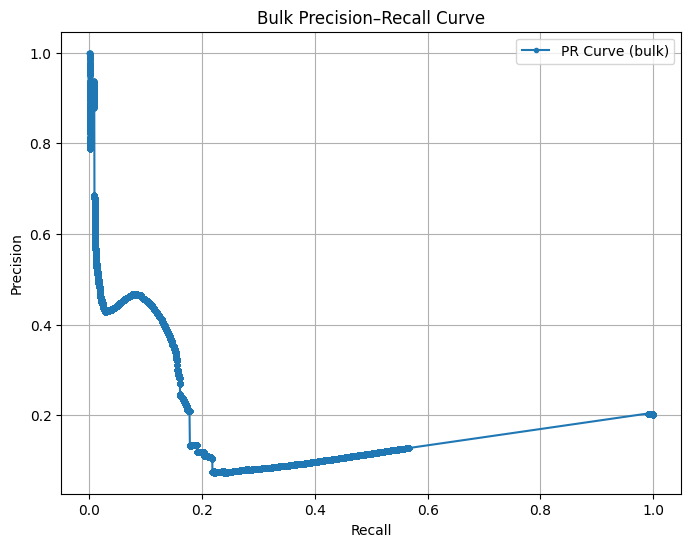

In [28]:
plot_bulk_prc(model, test_dataset, device)

### Validate Prediction with Test Pathway

**Extract single graph**

In [29]:
single_test_data = test_dataset[-2].to(device)

In [30]:
single_test_data.x.size()

torch.Size([17407, 1])

**Run model forward pass for single test graph**

In [31]:
model.eval()
with torch.no_grad():
    logits = model(single_test_data)
    y_prob = torch.sigmoid(logits).cpu().numpy()
    y_pred = (y_prob > 0.5).astype(int)
    y_true = single_test_data.y.cpu().numpy()

**Identify TP/FP/FN edges**

In [32]:
tp_mask = (y_true == 1) & (y_pred == 1)
fp_mask = (y_true == 0) & (y_pred == 1)
fn_mask = (y_true == 1) & (y_pred == 0)

In [33]:
num_tp = np.sum(tp_mask)
num_fp = np.sum(fp_mask)
num_fn = np.sum(fn_mask)

print(f"True Positives (TP): {num_tp}")
print(f"False Positives (FP): {num_fp}")
print(f"False Negatives (FN): {num_fn}")

True Positives (TP): 1
False Positives (FP): 136
False Negatives (FN): 0


**Convert to NetworkX graph (only plot TP/FP/FN edges)**

In [34]:
edge_index = single_test_data.edge_index.cpu().numpy()
G = nx.Graph()

In [35]:
# add only TP/FP/FN edges to reduce clutter
for i, (src, dst) in enumerate(edge_index.T):
    if tp_mask[i] or fp_mask[i] or fn_mask[i]:
        G.add_edge(src, dst)

**Assign edge colors**

In [36]:
edge_colors = []
for i, (src, dst) in enumerate(edge_index.T):
    if tp_mask[i]:
        # TP -> green
        edge_colors.append("green")  
    elif fp_mask[i]:
        # FP -> red
        edge_colors.append("red")    
    elif fn_mask[i]:
        # FN -> blue
        edge_colors.append("blue")  

**Draw the graph (only TP/FP/FN edges)**

In [37]:
# plt.figure(figsize=(12, 10))
# pos = nx.spring_layout(G, k=0.15, iterations=50)  # Force-directed layout
# nx.draw(
#     G,
#     pos,
#     edge_color=edge_colors,
#     node_size=20,
#     node_color="lightgray",
#     width=1.0,
#     with_labels=False,
# )
# plt.title("Network: TP (Green), FP (Red), FN (Blue)")
# plt.show()

**Print metrics for this graph**

In [38]:
# precision = precision_score(y_true, y_pred, zero_division=0)
# recall = recall_score(y_true, y_pred, zero_division=0)
# f1 = f1_score(y_true, y_pred, zero_division=0)
# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

### Compute PRC for each `Data` object

In [41]:
def compute_prc_for_dataset(model, dataset, device):
    model.eval()
    prc_dict = {}

    for data in dataset:
        # --- 1) extract the raw prefix from the filename ---
        raw_name = data.file_name                            
        prefix   = raw_name.split('_train_')[0]

        # --- 2) sanitize exactly as in your preprocessing script ---
        #    replace every non-word (\W+) with '_', strip leading/trailing '_', lowercase
        sanitized = re.sub(r'\W+', '_', prefix).strip('_').lower()
        lookup_fp = os.path.join(
            'processed-pc-individual-pathways',
            f"{sanitized}.txt"
        )

        if not os.path.isfile(lookup_fp):
            # raise FileNotFoundError(f"No processed pathway file found at: {lookup_fp}")
            print(f"No processed pathway file found at: {lookup_fp} for dataset {data.file_name}")
            continue

        # --- 3) read in the gold-standard edges ---
        pathway_df = pd.read_csv(lookup_fp, sep='\t')

        # --- 4) build the undirected gold-edge set ---
        gold_edges = set()
        for _, row in pathway_df.iterrows():
            a, b = row['Node1'], row['Node2']
            gold_edges.add(tuple(sorted((a, b))))

        # --- 5) get model scores ---
        with torch.no_grad():
            logits = model(data.to(device))
            probs  = torch.sigmoid(logits).view(-1).cpu().numpy()

        # --- 6) override y_true based on gold_edges ---
        src, dst = data.edge_index
        src, dst = src.cpu().numpy(), dst.cpu().numpy()
        y_true = np.array([
            1 if tuple(sorted((inv_label_map[u], inv_label_map[v]))) in gold_edges else 0
            for u, v in zip(src, dst)
        ], dtype=int)

        # --- 7) compute precision–recall & AP ---
        precision, recall, thresholds = precision_recall_curve(y_true, probs)
        ap = average_precision_score(y_true, probs)

        prc_dict[raw_name] = {
            'precision': precision,
            'recall': recall,
            'thresholds': thresholds,
            'average_precision': ap,
            'pathway_df': pathway_df
        }

    return prc_dict


In [42]:
model = model.to(device)
train_prc = compute_prc_for_dataset(model, train_dataset, device)
test_prc  = compute_prc_for_dataset(model, test_dataset,  device)

No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset glycosaminoglycan_bi__1_train_4029.csv
No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset glycosaminoglycan_bi__1_train_4495.csv
No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset glycosaminoglycan_bi__1_train_4603.csv
No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset glycosaminoglycan_bi__1_train_5286.csv
No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset glycosaminoglycan_bi__1_train_5476.csv
No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset glycosaminoglycan_bi__1_train_6041.csv
No processed pathway file found at: processed-pc-individual-pathways/glycosaminoglycan_bi__1.txt for dataset gly

In [43]:
rows = []
for fn, info in train_prc.items():
    rows.append({
      'file_name': fn,
      'precision': info['precision'],
      'recall': info['recall'],
      'thresholds': info['thresholds'],
      'average_precision': info['average_precision']
    })

train_prc_df = pd.DataFrame(rows)

In [44]:
train_prc_df.head()

,file_name,precision,recall,thresholds,average_precision
0,alanine__aspartate_a_train_2535.csv,"[0.0012913759833753896, 0.0012913823728780015,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0011959524, 0.0012502815, 0.001367893, 0.00...",0.191173
1,alanine__aspartate_a_train_3273.csv,"[0.001227133505197999, 0.001227139577230623, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0020992365, 0.0021502003, 0.0021812348, 0.0...",0.078431
2,alanine__aspartate_a_train_3711.csv,"[0.0013012587080430652, 0.0013012780232448827,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.972743e-05, 0.00013231131, 0.00013245876, 0...",0.251967
3,alanine__aspartate_a_train_3781.csv,"[0.0012469013018243354, 0.0012469074715487382,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.8217794e-05, 0.0011892465, 0.002617406, 0.0...",0.101482
4,alanine__aspartate_a_train_6130.csv,"[0.0012419594260267195, 0.001241965571328903, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.4209523e-05, 0.0018694638, 0.001916065, 0.0...",0.130673


In [45]:
test_rows = []
for fn, info in test_prc.items():
    test_rows.append({
      'file_name': fn,
      'precision': info['precision'],
      'recall': info['recall'],
      'thresholds': info['thresholds'],
      'average_precision': info['average_precision']
    })

test_prc_df = pd.DataFrame(test_rows)

In [46]:
test_prc_df.head()

,file_name,precision,recall,thresholds,average_precision
0,alpha_linolenic_acid_train_4939.csv,"[0.00045524271364243656, 0.0004502966514753401...","[1.0, 0.9891304347826086, 0.9891304347826086, ...","[0.0016099933, 0.0030466935, 0.0030559262, 0.0...",0.073416
1,aminoacyl_trna_biosy_train_2796.csv,"[0.0008313127814340146, 0.0008263685801800197,...","[1.0, 0.9940476190476191, 0.9940476190476191, ...","[5.7083907e-05, 0.00010559698, 0.00013245876, ...",0.091203
2,aminoacyl_trna_biosy_train_5354.csv,"[0.0008313127814340146, 0.0008214243299948538,...","[1.0, 0.9880952380952381, 0.9880952380952381, ...","[4.0828763e-05, 9.5048046e-05, 0.00013245876, ...",0.101673
3,aminoacyl_trna_biosy_train_8954.csv,"[0.0008313127814340146, 0.0008214243299948538,...","[1.0, 0.9880952380952381, 0.9880952380952381, ...","[3.7108697e-05, 0.0012369639, 0.0014624246, 0....",0.123547
4,arachidonic_acid_met_train_3652.csv,"[0.0033252511257360583, 0.0033252675801255884,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0021353522, 0.0028464682, 0.0029387244, 0.0...",0.211526


**Save these dataframes**

In [47]:
test_prc_df.to_csv('test_prc_values.csv', sep='\t')

In [48]:
train_prc_df.to_csv('train_prc_values.csv', sep='\t')